In [1]:
from glob import glob
import sys
import getpass
import os
# import psutil
from os.path import join, exists
from os.path import getsize
import pickle
import numpy as np
import pandas as pd
import scipy

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.stats.multitest
# from statsmodels.sandbox.stats.multicomp import multipletests

# import nilearn.masking
from nilearn import plotting as nplt
from nilearn import image as niimg
import nilearn.decoding

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
# from sklearn.svm import LinearSVC

# import mydef as my Class correction for projects
import mydef

/home/sungbeenpark/anaconda3/envs/sampark/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
GA = mydef.GA()

OS : linux
Google Drive is detected!
Git directory is detected!


---

## 0. ROIs

- Visual areas, DMN Core, and motor system

In [3]:
dir_root = '/home/sungbeenpark/GA'
stat = 'GLM.MO'

In [4]:
dir_tsmean = join(dir_root, stat, 'tsmean')

rois = []
for ss in glob(join(dir_tsmean, '*')):
    if os.path.isdir(ss):
        rois.append(ss.split('/')[-1])
rois = np.array(sorted(rois))
rois = rois[(rois!='fan_all')&(rois!='full_mask')]
rois

array(['Core_PCC_l', 'Core_PCC_r', 'Core_aMPFC_l', 'Core_aMPFC_r',
       'MTLsub_HF_l', 'MTLsub_HF_r', 'MTLsub_PHC_l', 'MTLsub_PHC_r',
       'MTLsub_Rsp_l', 'MTLsub_Rsp_r', 'MTLsub_pIPL_l', 'MTLsub_pIPL_r',
       'MTLsub_vMPFC', 'dMsub_LTC_l', 'dMsub_LTC_r', 'dMsub_TPJ_l',
       'dMsub_TPJ_r', 'dMsub_TempP_l_temp', 'dMsub_TempP_r_temp',
       'dMsub_dMPFC', 'fan105', 'fan106', 'fan189', 'fan190', 'fan193',
       'fan194', 'fan196', 'fan199', 'fan200', 'fan203', 'fan204',
       'fan205', 'fan206', 'fan209', 'n200_c1_L_Postcentral',
       'n200_c2_R_CerebellumIV-V', 'n200_c3_R_Postcentral',
       'n200_c4_L_Putamen', 'n200_c5_R_SMA', 'n200_c6_R_CerebellumVIIIb',
       'n200_c7_L_Thalamus'], dtype='<U25')

## 1. Calculating Functional Correlation

- Calculating a correlation by tsmean.bp_demean.errts (run once), then save the result.

In [12]:
runs = ['r%02d'%(i+1) for i in range(6)]

list_ = []
for stage in GA.list_stage:
    runs = ['r01', 'r02', 'r03'] if 'practice' in stage else (['r04', 'r05', 'r06'] if 'unpractice' in stage else 'invalid')
    for subj in GA.list_subj:
        for run in runs:
            for i, a in enumerate(rois):
                for b in rois[i+1:]:
                    list_.append([stage, subj, run, a, b])
list_ = np.array(list_)
list_.shape

(295200, 5)

In [13]:
pname = 'tsmean.bp_demean.errts.%s'%stat[-2:]
# pname = 'tsmean.errts_tproject_bp'

idxs = []
idx = 0
for stage, subj, run, roia, roib in tqdm(list_):
    gg = 'GA' if 'early' in stage else ('GB' if 'late' in stage else 'invalid')
    
    A = join(dir_tsmean,roia,'%s.%s.%s.%s.1D'%(pname,gg+subj,run,roia))
    B = join(dir_tsmean,roib,'%s.%s.%s.%s.1D'%(pname,gg+subj,run,roib))

    if os.path.isfile(A) and os.path.isfile(B):
        idxs.append(idx)
    idx += 1
list_ = list_[idxs]
list_.shape

100%|██████████| 295200/295200 [00:02<00:00, 111370.37it/s]


(295200, 5)

30 subjects * 12 runs * 41C2 pairs = 295200

In [14]:
lines = []
previous = {}
previous['stage'] = ''
previous['subj'] = ''
previous['run'] = ''

ort_global = False

for stage, subj, run, roia, roib in tqdm(list_):
    gg = 'GA' if 'early' in stage else ('GB' if 'late' in stage else 'invalid')
    
    a = GA.load_tsmean_1D(
        join(dir_tsmean,roia,'%s.%s.%s.%s.1D'%(pname,gg+subj,run,roia))
    )
    b = GA.load_tsmean_1D(
        join(dir_tsmean,roib,'%s.%s.%s.%s.1D'%(pname,gg+subj,run,roib))
    )

    if ort_global:
        if previous['stage']!=stage or previous['subj']!=subj or previous['run']!=run:
            roi = 'full_mask'
            global_activity = GA.load_tsmean_1D(
                join(dir_tsmean,roi,'%s.%s.%s.%s.1D'%(pname,gg+subj,run,roi))
            )
            z = global_activity / np.linalg.norm(global_activity)
            M = np.outer(z, z)

        ## partial correlation
        a = a - np.matmul(M, a)
        b = b - np.matmul(M, b)
    
    r, p = scipy.stats.pearsonr(x=a, y=b)
    lines.append([subj, stage, run, roia, roib, r, p])
    
    ## renew
    previous['stage'] = stage
    previous['subj'] = subj
    previous['run'] = run

GA.df_functional_correlation = pd.DataFrame(lines, columns=GA.df_functional_correlation.columns)

100%|██████████| 295200/295200 [18:53<00:00, 260.53it/s]


In [15]:
tmp = '.ort_global' if ort_global else ''
GA.save_as_pkl(data=GA.df_functional_correlation
               , path=dir_tsmean
               , suffix="df.functional_correlation.%s.DMN-visual-localizer%s"%(pname, tmp))

## 2. Bring about the above results

In [16]:
tmp = GA.show_pkl_list(path=join(dir_tsmean) , word="corr")
# tmp = GA.show_pkl_list(path=dir_stats , word="corr")
tmp

file  \
0  /home/sungbeenpark/GA/GLM.MO/tsmean/20211104.d...   

                                                name identity  
0  20211104.df.functional_correlation.tsmean.bp_d...        a

In [17]:
idx = 0

fname = list(tmp.name)[idx]
print(fname)

with open(list(tmp.file)[idx], 'rb') as fr:
    GA.df_functional_correlation = pickle.load(fr)
GA.df_functional_correlation

20211104.df.functional_correlation.tsmean.bp_demean.errts.MO.DMN-visual-localizer.pkl


subj            stage  run                       roiA  \
0        01   early_practice  r01                 Core_PCC_l   
1        01   early_practice  r01                 Core_PCC_l   
2        01   early_practice  r01                 Core_PCC_l   
3        01   early_practice  r01                 Core_PCC_l   
4        01   early_practice  r01                 Core_PCC_l   
...     ...              ...  ...                        ...   
295195   44  late_unpractice  r03          n200_c4_L_Putamen   
295196   44  late_unpractice  r03          n200_c4_L_Putamen   
295197   44  late_unpractice  r03              n200_c5_R_SMA   
295198   44  late_unpractice  r03              n200_c5_R_SMA   
295199   44  late_unpractice  r03  n200_c6_R_CerebellumVIIIb   

                             roiB  Pearson_r           pval  
0                      Core_PCC_r   0.898462   0.000000e+00  
1                    Core_aMPFC_l   0.694388  1.579097e-158  
2                    Core_aMPFC_r   0.574191   3.919469e-97  
3                     MTLsub_HF_l   0.517518   4.089809e-76  
4                     MTLsub_HF_r   0.477061   2.269743e-63  
...                           ...        ...            ...  
295195  n200_c6_R_CerebellumVIIIb   0.729354  1.463714e-182  
295196         n200_c7_L_Thalamus   0.719102  3.899624e-175  
295197  n200_c6_R_CerebellumVIIIb   0.829707  2.824152e-279  
295198         n200_c7_L_Thalamus   0.716477  2.750078e-173  
295199         n200_c7_L_Thalamus   0.717807  3.202472e-174  

[295200 rows x 7 columns]

In [18]:
sorted_rois = sorted(set(list(GA.df_functional_correlation.roiA.unique())+list(GA.df_functional_correlation.roiB.unique())))
print(len(sorted_rois), sorted_rois)

41 ['Core_PCC_l', 'Core_PCC_r', 'Core_aMPFC_l', 'Core_aMPFC_r', 'MTLsub_HF_l', 'MTLsub_HF_r', 'MTLsub_PHC_l', 'MTLsub_PHC_r', 'MTLsub_Rsp_l', 'MTLsub_Rsp_r', 'MTLsub_pIPL_l', 'MTLsub_pIPL_r', 'MTLsub_vMPFC', 'dMsub_LTC_l', 'dMsub_LTC_r', 'dMsub_TPJ_l', 'dMsub_TPJ_r', 'dMsub_TempP_l_temp', 'dMsub_TempP_r_temp', 'dMsub_dMPFC', 'fan105', 'fan106', 'fan189', 'fan190', 'fan193', 'fan194', 'fan196', 'fan199', 'fan200', 'fan203', 'fan204', 'fan205', 'fan206', 'fan209', 'n200_c1_L_Postcentral', 'n200_c2_R_CerebellumIV-V', 'n200_c3_R_Postcentral', 'n200_c4_L_Putamen', 'n200_c5_R_SMA', 'n200_c6_R_CerebellumVIIIb', 'n200_c7_L_Thalamus']


In [19]:
rois_ = {}

rois_['Core'] = sorted_rois[:4]
rois_['MTLsub'] = sorted_rois[4:13]
rois_['dMsub'] = sorted_rois[13:20]
# rois_['DMN'] = sorted_rois[:20]
# rois_['task-negative'] = sorted_rois[:20]
rois_['Yeo1'] = sorted_rois[20:34]
rois_['localizer'] = sorted_rois[34:]
# rois_['task-positive'] = sorted_rois[20:]

rois_

{'Core': ['Core_PCC_l', 'Core_PCC_r', 'Core_aMPFC_l', 'Core_aMPFC_r'],
 'MTLsub': ['MTLsub_HF_l',
  'MTLsub_HF_r',
  'MTLsub_PHC_l',
  'MTLsub_PHC_r',
  'MTLsub_Rsp_l',
  'MTLsub_Rsp_r',
  'MTLsub_pIPL_l',
  'MTLsub_pIPL_r',
  'MTLsub_vMPFC'],
 'dMsub': ['dMsub_LTC_l',
  'dMsub_LTC_r',
  'dMsub_TPJ_l',
  'dMsub_TPJ_r',
  'dMsub_TempP_l_temp',
  'dMsub_TempP_r_temp',
  'dMsub_dMPFC'],
 'Yeo1': ['fan105',
  'fan106',
  'fan189',
  'fan190',
  'fan193',
  'fan194',
  'fan196',
  'fan199',
  'fan200',
  'fan203',
  'fan204',
  'fan205',
  'fan206',
  'fan209'],
 'localizer': ['n200_c1_L_Postcentral',
  'n200_c2_R_CerebellumIV-V',
  'n200_c3_R_Postcentral',
  'n200_c4_L_Putamen',
  'n200_c5_R_SMA',
  'n200_c6_R_CerebellumVIIIb',
  'n200_c7_L_Thalamus']}

In [20]:
## A array representing group types
group = []
cnt = 1
for _, value in rois_.items():
    temp = np.ones(len(value)) * cnt
    group.append(temp)
    cnt += 1
group = np.concatenate(group).astype(int)
group

array([1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5])

In [21]:
def comb_group(group):
    list_ = np.unique(group).astype(int)

    res = []
    for i, g1 in enumerate(list_):
        for g2 in list_[:i+1]:
            res.append(sorted([g1, g2]))
    return res

comb_group(group)

[[1, 1],
 [1, 2],
 [2, 2],
 [1, 3],
 [2, 3],
 [3, 3],
 [1, 4],
 [2, 4],
 [3, 4],
 [4, 4],
 [1, 5],
 [2, 5],
 [3, 5],
 [4, 5],
 [5, 5]]

## 3. Calculating Interaction Strength through Quick & Dirty Method

In [22]:
# ## The module 'GA.make_df_correlation_matrix' is work?
# subj = '26'
# stage = 'early_practice'

# print(subj, stage)
# GA.make_df_correlation_matrix(subj, stage, group=group)

In [23]:
subjs = GA.df_functional_correlation.subj.unique()
subjs

array(['01', '02', '05', '07', '08', '11', '12', '13', '14', '15', '18',
       '19', '20', '21', '23', '26', '27', '28', '29', '30', '31', '32',
       '33', '34', '35', '36', '37', '38', '42', '44'], dtype=object)

In [24]:
## Initializing a result variable
res = {}
for [g1,g2] in comb_group(group):
    res[(g1,g2)] = []

tmp = {}
## Main calculation
for subj in tqdm(subjs):
    corrmat = {}
    I = {}

    ## Matrix implementation & initializing an interaction variable
    for stage in ['early_practice', 'late_practice']:
        corrmat[stage] = GA.make_df_correlation_matrix(subj, stage, group=group)
        for [g1,g2] in comb_group(group):
            I[stage, (g1,g2)] = []
    ## Inserting elements of the matrix one by one
    for stage in ['early_practice', 'late_practice']:
        for a, roiA in enumerate(sorted_rois):
            for b, roiB in enumerate(sorted_rois):
                [g1,g2] = sorted([group[a], group[b]])
                element = corrmat[stage].loc[roiA][roiB]
                I[stage, (g1,g2)].append(element)

    ## Normalizing interaction strength
    Ip = {}
    for [g1,g2] in comb_group(group):
        for stage in ['early_practice', 'late_practice']:
            if g1==g2:
                Ip[stage,(g1,g2)] = np.mean(I[stage,(g1,g2)])
            else:
                Ip[stage,(g1,g2)] = np.mean(I[stage,(g1,g2)])/np.sqrt(np.mean(I[stage,(g1,g1)])*np.mean(I[stage,(g2,g2)]))
            tmp[(subj,stage,g1,g2)] = Ip[stage,(g1,g2)]
        res[(g1,g2)].append(Ip['late_practice',(g1,g2)] - Ip['early_practice',(g1,g2)])

100%|██████████| 30/30 [01:13<00:00,  2.44s/it]


In [25]:
# ## check the validation

# for stage in GA.list_stage:
#     for [g1,g2] in comb_group(group):
#         n_g1 = (group == g1).sum()
#         n_g2 = (group == g2).sum()
#         correction = 1 if g1==g2 else 2
#         print(subj, stage, g1, g2, '%d*%d*%d='%(n_g1, n_g2, correction), len(I[stage, (g1,g2)]))

## 4. Correlation between the change in the visual-DMN core integration and improvement in success rate

In [26]:
def convert_key_into_regions(rois, key):
    (g1,g2) = key
    a, b = list(rois.keys())[g1-1], list(rois.keys())[g2-1]
    return a, b

In [27]:
def plot_interaction(X, Y, key, ax):
    ax = sns.regplot(x=X, y=Y, ci=GA.sig1*100, truncate=False, ax=ax)
    a, b = convert_key_into_regions(rois=rois_, key=key)
    ax.set_ylabel('Reward GB-GA')
    ax.set_xlabel('%s_%s GB-GA'%(a,b))
    ax.set_title('r=%.4f (p=%.3f)' % (*scipy.stats.pearsonr(x=X, y=Y),))
    ax.set_xlim(-0.6, 0.6)
    ax.set_ylim(-0., 0.8)
    ax.axvline(x=0, color='k', linestyle='--', alpha=0.25)

In [28]:
df = pd.DataFrame(columns=['subj', 'stage', 'groupA', 'groupB', 'int_str'])
for i, ((subj, stage, a, b), val) in enumerate(tmp.items()):
    df.loc[i,'subj'] = subj
    df.loc[i,'stage'] = stage
    df.loc[i,'groupA'] = a
    df.loc[i,'groupB'] = b
    df.loc[i,'int_str'] = val
df

subj           stage groupA groupB   int_str
0     01  early_practice      1      1  0.842434
1     01   late_practice      1      1  0.715286
2     01  early_practice      1      2  0.876799
3     01   late_practice      1      2  0.800977
4     01  early_practice      2      2  0.709329
..   ...             ...    ...    ...       ...
895   44   late_practice      3      5  0.199031
896   44  early_practice      4      5  0.670334
897   44   late_practice      4      5  0.693739
898   44  early_practice      5      5  0.674039
899   44   late_practice      5      5  0.752331

[900 rows x 5 columns]

[(1, 1), (2, 2), (3, 3), (4, 4), (5, 5)]


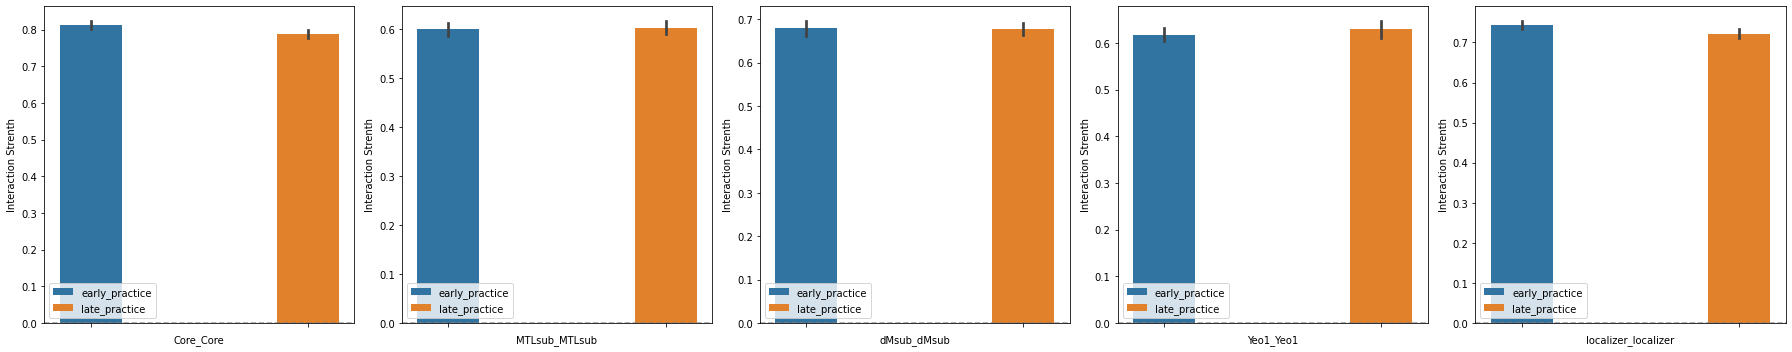

In [29]:
tmp = []
for g1, g2 in res.keys():
    if g1==g2:
        tmp.append((g1,g2))
print(tmp)
ncol=len(tmp)

fig, axs = plt.subplots(nrows=1, ncols=ncol, figsize=(ncol*5,5))
for i, (a, b) in enumerate(tmp):
    ax = axs[i] if ncol > 1 else axs
    ax = sns.barplot(x='stage', y='int_str', hue='stage'
                     , data=df[(df.groupA==a) & (df.groupB==b)]
                     , ax=ax, ci=GA.sig1*100)
    p, q = convert_key_into_regions(rois_, (a,b))
    ax.set(xlabel="%s_%s"%(p,q), ylabel="Interaction Strenth", xticks=(-0.2, 1.2))
    ax.axhline(y=0, color='gray', linestyle='--', alpha=.8)
    ax.legend(loc='best')
fig.tight_layout() 

[(1, 2), (1, 3), (2, 3), (1, 4), (2, 4), (3, 4), (1, 5), (2, 5), (3, 5), (4, 5)]


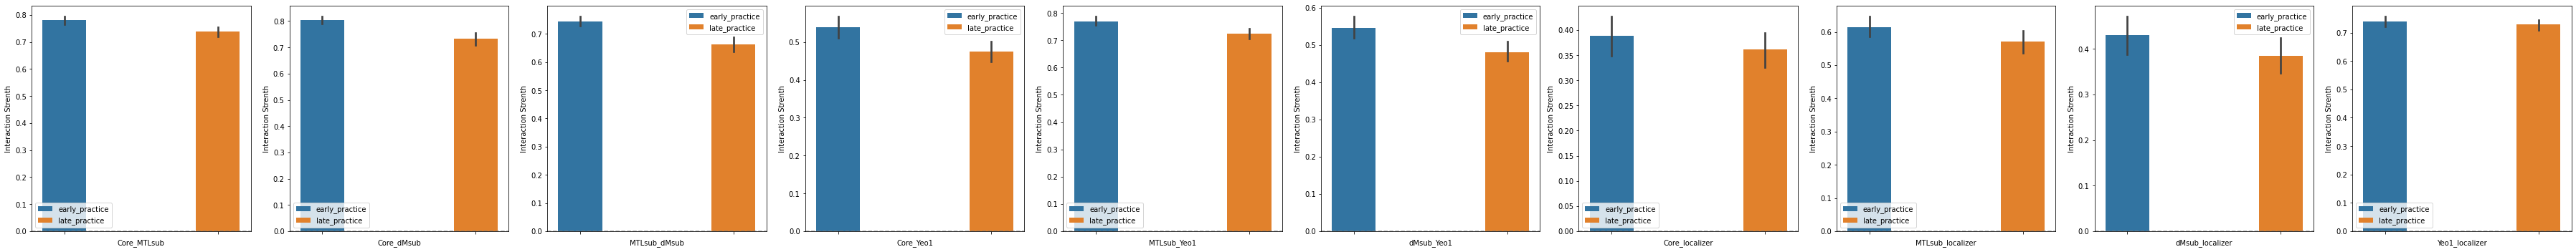

In [30]:
tmp = []
for g1, g2 in res.keys():
    if g1!=g2:
        tmp.append((g1,g2))
print(tmp)
ncol=len(tmp)

fig, axs = plt.subplots(nrows=1, ncols=ncol, figsize=(ncol*5,5))
for i, (a, b) in enumerate(tmp):
    ax = axs[i] if ncol > 1 else axs
    ax = sns.barplot(x='stage', y='int_str', hue='stage'
                     , data=df[(df.groupA==a) & (df.groupB==b)]
                     , ax=ax, ci=GA.sig1*100)
    p, q = convert_key_into_regions(rois_, (a,b))
    ax.set(xlabel="%s_%s"%(p,q), ylabel="Interaction Strenth", xticks=(-0.2, 1.2))
    ax.axhline(y=0, color='gray', linestyle='--', alpha=.8)
    ax.legend(loc='best')
fig.tight_layout() 

[(1, 1), (2, 2), (3, 3), (4, 4), (5, 5)]


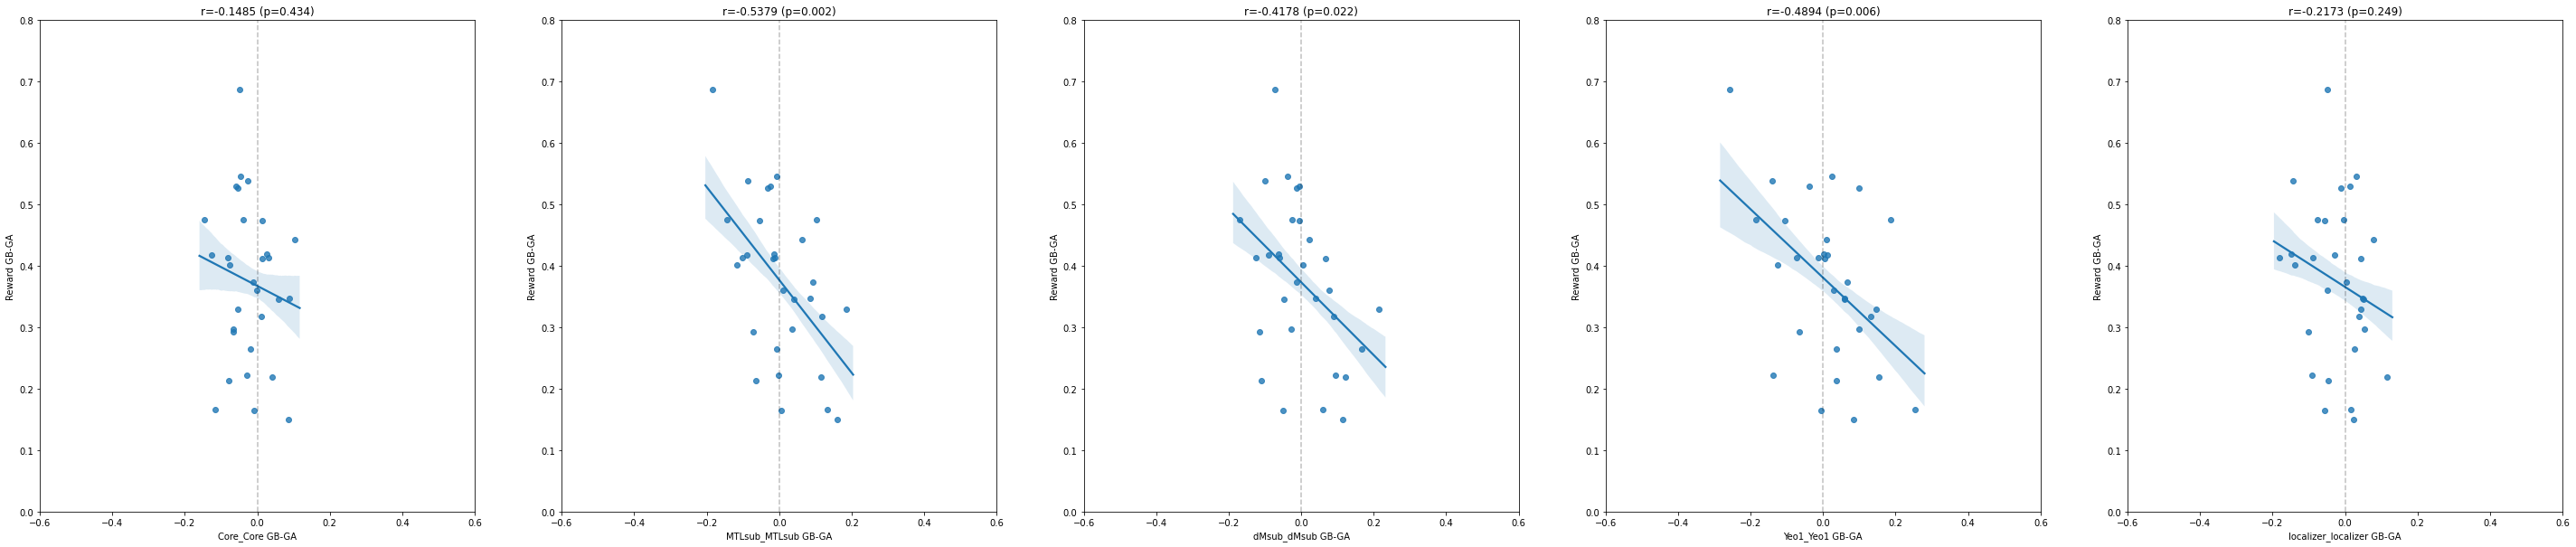

In [31]:
Y = GA.del_RewardRate

tmp = []
for g1, g2 in res.keys():
    if g1==g2:
        tmp.append((g1,g2))
print(tmp)
ncol=len(tmp)
fig, axs = plt.subplots(nrows=1, ncols=ncol, figsize=(10*ncol,10))
for i, (g1, g2) in enumerate(tmp):
    key = (g1,g2)
    X = res[key]
    ax = axs[i] if ncol > 1 else axs
    plot_interaction(X, Y, key=key, ax=ax)

# fig.savefig(fname=join(GA.dir_git, 'GA/images/%s.DMN_Yeo17_Localizer.png'%GA.today))

[(1, 2), (1, 3), (2, 3), (1, 4), (2, 4), (3, 4), (1, 5), (2, 5), (3, 5), (4, 5)]


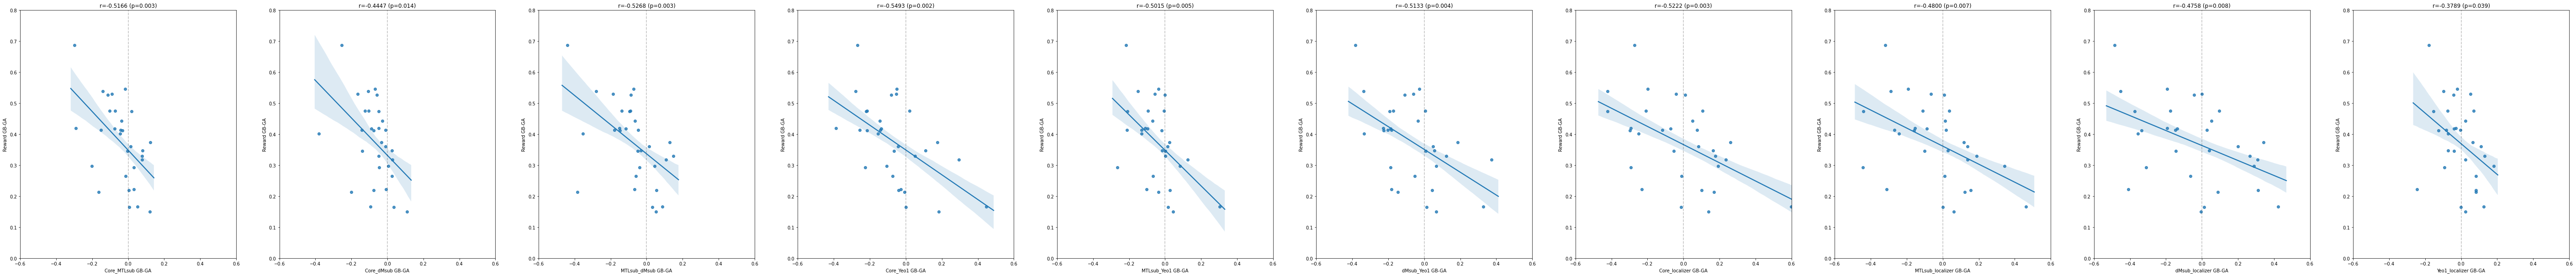

In [32]:
Y = GA.del_RewardRate

tmp = []
for g1, g2 in res.keys():
    if g1!=g2:
        tmp.append((g1,g2))
print(tmp)
ncol=len(tmp)
fig, axs = plt.subplots(nrows=1, ncols=ncol, figsize=(10*ncol,10))
for i, (g1, g2) in enumerate(tmp):
    key = (g1,g2)
    X = res[key]
    ax = axs[i] if ncol > 1 else axs
    plot_interaction(X, Y, key=key, ax=ax)

# fig.savefig(fname=join(GA.dir_git, 'GA/images/%s.DMN_Yeo17_Localizer.png'%GA.today))

In [33]:
## Lower-Tailed t-Test
for key, X in res.items():
    a, b = convert_key_into_regions(rois=rois_, key=key)
    print('%s_%s: '%(a,b), scipy.stats.ttest_1samp(X, popmean=0, alternative='less'))

Core_Core:  Ttest_1sampResult(statistic=-1.994957560577406, pvalue=0.027760261270134656)
Core_MTLsub:  Ttest_1sampResult(statistic=-2.124050824052965, pvalue=0.021158526182296796)
MTLsub_MTLsub:  Ttest_1sampResult(statistic=0.20851408352906167, pvalue=0.5818573932477495)
Core_dMsub:  Ttest_1sampResult(statistic=-4.0595309731073925, pvalue=0.0001701348544710371)
MTLsub_dMsub:  Ttest_1sampResult(statistic=-3.0334512436292407, pvalue=0.00252896224393592)
dMsub_dMsub:  Ttest_1sampResult(statistic=-0.10159922155513876, pvalue=0.45988701537129645)
Core_Yeo1:  Ttest_1sampResult(statistic=-1.9528153035037956, pvalue=0.030276459976303276)
MTLsub_Yeo1:  Ttest_1sampResult(statistic=-2.22450194411617, pvalue=0.017029008493311768)
dMsub_Yeo1:  Ttest_1sampResult(statistic=-1.946585822316961, pvalue=0.030664805424872637)
Yeo1_Yeo1:  Ttest_1sampResult(statistic=0.551655358326766, pvalue=0.7072946452820036)
Core_localizer:  Ttest_1sampResult(statistic=-0.6572960883873944, pvalue=0.25808693053588955)
MT

In [34]:
## Spearman correlation
for key, X in res.items():
    a, b = convert_key_into_regions(rois=rois_, key=key)
    print('%s_%s: '%(a,b), scipy.stats.spearmanr(X,Y))

Core_Core:  SpearmanrResult(correlation=-0.12124582869855395, pvalue=0.5233214598378129)
Core_MTLsub:  SpearmanrResult(correlation=-0.5403781979977753, pvalue=0.0020514547662183304)
MTLsub_MTLsub:  SpearmanrResult(correlation=-0.517686318131257, pvalue=0.003389923154662725)
Core_dMsub:  SpearmanrResult(correlation=-0.4687430478309232, pvalue=0.00898147665666598)
MTLsub_dMsub:  SpearmanrResult(correlation=-0.607119021134594, pvalue=0.00037445890099600327)
dMsub_dMsub:  SpearmanrResult(correlation=-0.4082313681868743, pvalue=0.025119951782871273)
Core_Yeo1:  SpearmanrResult(correlation=-0.5692992213570635, pvalue=0.0010258884981883543)
MTLsub_Yeo1:  SpearmanrResult(correlation=-0.521245828698554, pvalue=0.0031401805607080865)
dMsub_Yeo1:  SpearmanrResult(correlation=-0.511012235817575, pvalue=0.0039044434644538925)
Yeo1_Yeo1:  SpearmanrResult(correlation=-0.4331479421579533, pvalue=0.016803445192878536)
Core_localizer:  SpearmanrResult(correlation=-0.49454949944382637, pvalue=0.005468034

In [35]:
## wilcoxon signed rank test
for key, X in res.items():
    a, b = convert_key_into_regions(rois=rois_, key=key)
    print('%s_%s: '%(a,b), scipy.stats.wilcoxon(X))

Core_Core:  WilcoxonResult(statistic=142.0, pvalue=0.06268281249957977)
Core_MTLsub:  WilcoxonResult(statistic=151.0, pvalue=0.09367559653193051)
MTLsub_MTLsub:  WilcoxonResult(statistic=232.0, pvalue=0.9917945644340904)
Core_dMsub:  WilcoxonResult(statistic=53.0, pvalue=0.00022248266458074938)
MTLsub_dMsub:  WilcoxonResult(statistic=99.0, pvalue=0.006035006473812041)
dMsub_dMsub:  WilcoxonResult(statistic=215.0, pvalue=0.7188875621362669)
Core_Yeo1:  WilcoxonResult(statistic=122.0, pvalue=0.023038144695472357)
MTLsub_Yeo1:  WilcoxonResult(statistic=116.0, pvalue=0.016565526979430395)
dMsub_Yeo1:  WilcoxonResult(statistic=140.0, pvalue=0.05709649524315731)
Yeo1_Yeo1:  WilcoxonResult(statistic=193.0, pvalue=0.41653380739187873)
Core_localizer:  WilcoxonResult(statistic=194.0, pvalue=0.4284300285458069)
MTLsub_localizer:  WilcoxonResult(statistic=189.0, pvalue=0.37093530784512463)
dMsub_localizer:  WilcoxonResult(statistic=187.0, pvalue=0.34934556237492975)
Yeo1_localizer:  WilcoxonResul

## 5. *Drawing functional connectivity matrices (run once), then save it

In [38]:
list_ = []
stages = GA.list_stage
for i, subj in enumerate(subjs):
    for j, stage in enumerate(stages):  
        list_.append((subj, stage))

100%|██████████| 120/120 [21:34<00:00, 10.79s/it]


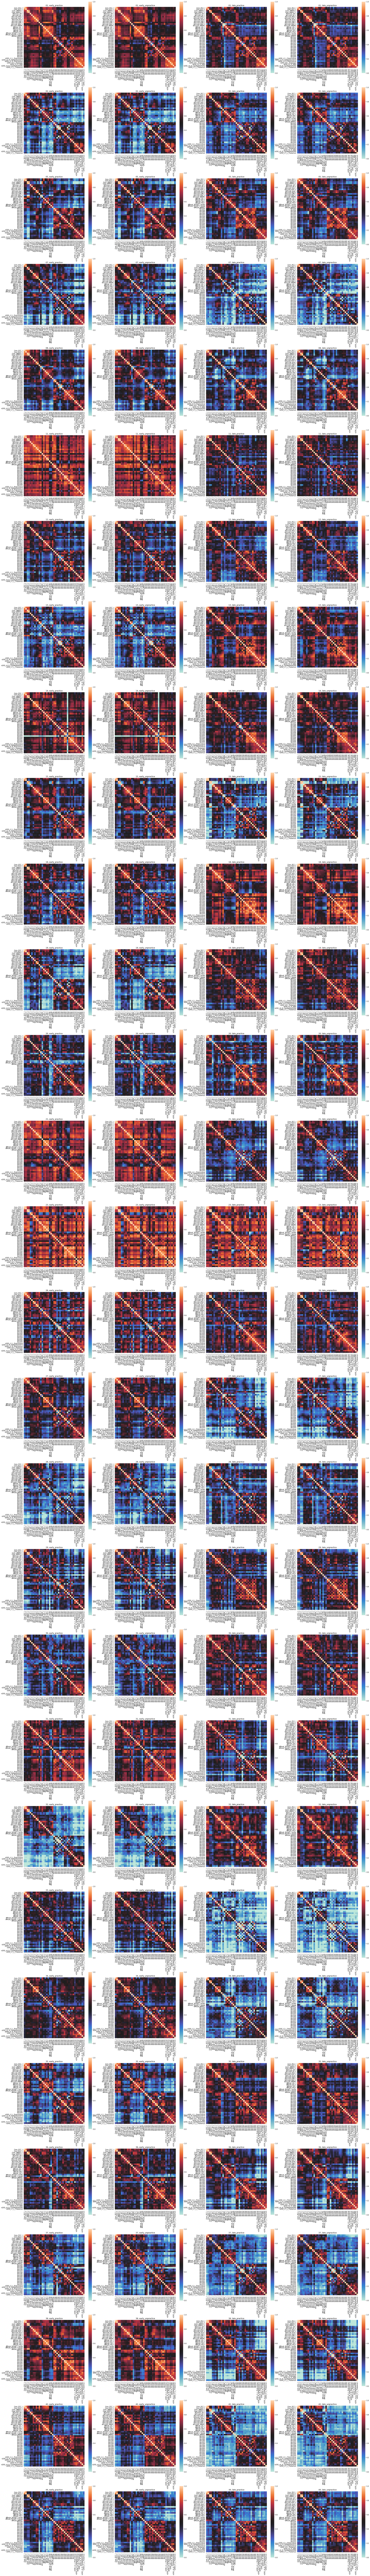

In [40]:
fig, axs = plt.subplots(nrows=len(subjs), ncols=len(stages), figsize=(len(stages)*10, len(subjs)*10))
if len(axs.shape)!=1:
    axs = np.concatenate(axs)

corrmats = {}
for i, (subj, stage) in enumerate(tqdm(list_)):
    corrmat = GA.make_df_correlation_matrix(subj, stage=stage, group=group)
    ## plot matrices by an individual subject
    ax = sns.heatmap(corrmat
                     , square=True, cmap='icefire', cbar=True
                     , robust=True
                     , vmin=0., vmax=1.
                     , xticklabels=sorted_rois, yticklabels=sorted_rois, ax=axs[i])
    ax.set_title('%s, %s'%(subj, stage))
    if i<len(stages):
        corrmats[stage] = corrmat
    else:
        corrmats[stage] += corrmat

## divide by a number of subjects to obtain the average value
for stage in GA.list_stage:
    for roiA in sorted_rois:
        for roiB in sorted_rois:
            corrmats[stage].loc[roiA,roiB] /= len(subjs)

In [41]:
# pname = '.'.join(fname.split('.')[3:-1])

# fig.savefig(fname=join(GA.dir_git,'GA/images/%s.individual_connectivity_matrices.%s.png'%(GA.today, pname)))

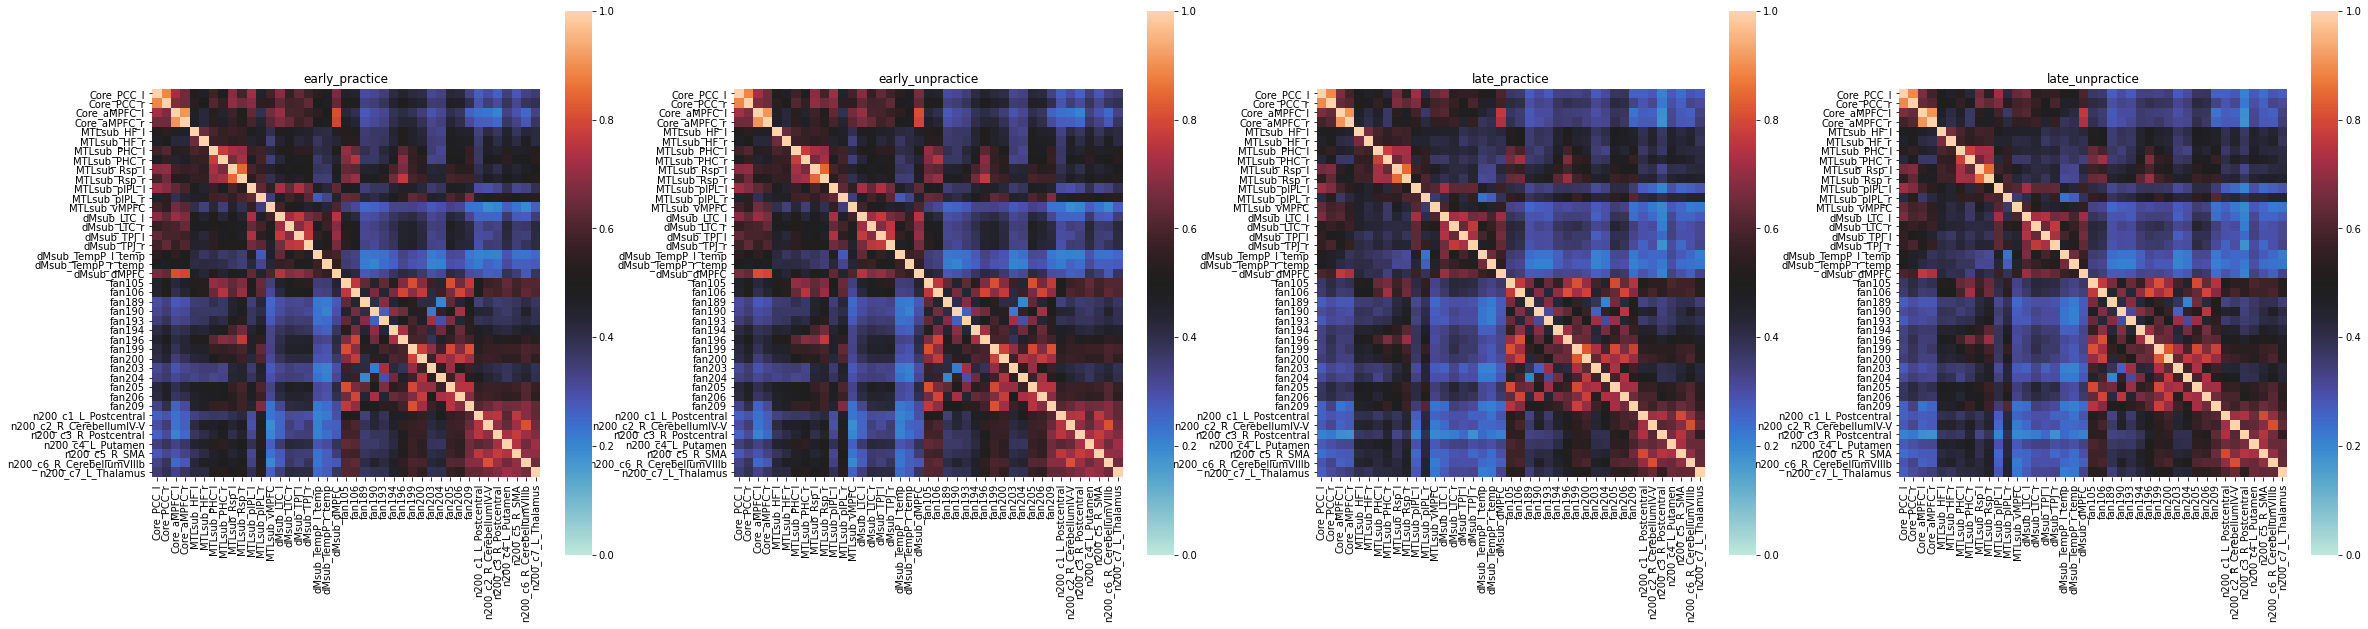

In [42]:
## plot group results
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(40, 10))
for i, stage in enumerate(GA.list_stage):
    ax = sns.heatmap(corrmats[stage]
                     , square=True
                     , cmap='icefire'
                     , cbar=True
#                      , robust=True
                     , vmin=0., vmax=1.
                     , xticklabels=sorted_rois, yticklabels=sorted_rois, ax=axs[i])
    ax.set_title('%s'%stage)        

In [40]:
# pname = '.'.join(fname.split('.')[3:-1])

# fig.savefig(fname=join(GA.dir_git,'GA/images/%s.group_connectivity_matrices.%s.png'%(GA.today, pname)))